<a href="https://colab.research.google.com/github/ybarmaz/blog/blob/master/posts/2024-07-07-SDE-model-calibration-through-NPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDE model calibration through neural posterior estimation
Last time, I discussed how [the differentiability of JAX programs facilitates model calibration](https://ybarmaz.github.io/blog/posts/2024-03-10-SDE-model-calibration-with-diffrax.html) when calculating derivatives by hand would be extremely tedious, for instance when the model involves the numerical integration of a stochastic differential equation. While this method provides point estimates of the parameters that minimize a given loss function, it does not quantify the uncertainty of those estimates. Getting such error bars is important to assess the quality of the calibration, and to decide whether the model actually explains the observed data. In the example of option pricing, this concretely means that we can detect mispricing for statistical arbitrage purposes.

In this post, I will be exploring a machine learning approach to this problem.

## Method
Mathematically, a model of a data-generating process can be roughly seen as a mapping

$$
F: \theta \mapsto X
$$

from parameters $\theta$ to random variables $X$ that we can potentially observe. We choose random variables rather than real numbers to account for uncertainty, both [epistemic and aleatoric](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic). In the [Heston model](https://en.wikipedia.org/wiki/Heston_model) example, $\theta$ represents the list of parameters of the system of stochastic differential equations, and $X$ the option prices. The main source of uncertainty is the realization of the Brownian motion in the SDE.

Given a loss function $L$ that penalizes discrepancies between the predictions $F(\theta)$ and the observed data $x_{\mathrm{observed}}$, calibration can be done as an optimization problem,

$$
\hat{\theta} = \mathrm{argmin}_\theta \, \mathbb{E}\left[ L\left( F(\theta), x_{\mathrm{observed}}\right)\right],
$$

where the expectation is taken over the random variable $X = F(\theta)$. In practice, it can be estimated with Monte Carlo methods.

If we want parameter estimates with quantified uncertainty, ideally we should aim for a conditional distribution $P(\theta \vert x_{\mathrm{observed}})$. In Bayesian statistics, such a distribution can be constructed by conditioning a joint distribution $P(\theta, X)$ on $X$ and plugging the data in,

$$
P(\theta \vert x_{\mathrm{observed}}) = P(\theta \vert X)\vert_{X = x_{\mathrm{observed}}}.
$$

Unsurprisingly, the conditioning

$$
P(\theta \vert X) = \frac{P(\theta, X)}{P(X)} = \frac{P(\theta)P(X \vert \theta)}{P(X)}
$$

is the tricky part, and not just because of the high-dimensional integration involved in the computation of the marginal $P(X)$, but also because a model $F: \theta \mapsto X$ very often has an intractable likelihood function. This happens when the density of the random variable $X=F(\theta)$ is hard (or even impossible) to derive. On the other hand, we can usually draw samples from this random variable, and use that to generate synthetic data. Concretely, we draw parameters from the prior, $\theta_i \sim P(\theta)$, and simulate observations from the model of the data-generating process, $x_i \sim X_i = F(\theta_i)$, for a certain number of times $i=1,\dots,N$, so that $(\theta_i, x_i) \sim P(\theta, X)$ are a sample of the joint distribution. This assumes that one can easily sample from the prior $P(\theta)$.

A [family of algorithms](https://arxiv.org/abs/1605.06376) in [simulation-based inference](https://www.pnas.org/doi/full/10.1073/pnas.1912789117) then leverage conditional density estimation to directly estimate the posterior density from this synthetic data, for instance with conditional [masked autoencoders](https://arxiv.org/abs/1502.03509). A distribution $q_{nn}(\theta \vert X)$ parameterized by such a neural network can be trained on the synthetic data through maximization of the log-likelihood to become a good approximation of the desired posterior distribution.

## Implementation
For the Heston model, we can reuse the code from the previous post to generate synthetic observations, but any implementation of a sampler of $x_i \sim X_i = F(\theta_i)$ would work.

In [2]:
#| echo: false
#| output: false
import jax.numpy as jnp
from jax import grad, jit, vmap
import jax
import jax.random as jr

import tensorflow_probability.substrates.jax as tfp_jax
tfd_jax = tfp_jax.distributions
tfb_jax = tfp_jax.bijectors

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers

import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import arviz as az

In [1]:
#| echo: false
#| output: false
!pip install diffrax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.3/171.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26


In [3]:
from diffrax import (diffeqsolve, ControlTerm, Euler, MultiTerm,
ODETerm, SaveAt, VirtualBrownianTree)

def drift(t, y, args):
    S, V = y
    r, V0, k, theta, xi, rho = args
    d_y = jnp.array([r * S, k * (theta - V)])
    return d_y

def diffusion(t, y, args):
    S, V = y
    V = jnp.maximum(V, 0.001)
    r, V0, k, theta, vol_of_vol, rho = args
    mixing = jnp.array([[1., 0.],
                        [rho, jnp.sqrt(1-rho**2)]])
    scale = jnp.diag(jnp.array([jnp.sqrt(V)*S,
                                jnp.sqrt(V)*vol_of_vol]))
    return scale @ mixing

def simulate_heston_process(args, saveat, t0, t1, key, dataset_size=100):
    @jit
    @vmap
    def get_data(key):
        bm_key, vol_key = jr.split(key, 2)

        bm = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(2,), key=bm_key)
        drift_term = ODETerm(drift)
        diffusion_term = ControlTerm(diffusion, bm)
        terms = MultiTerm(drift_term, diffusion_term)
        solver = Euler()
        dt0 = 0.005

        r, V0, k, theta, sigma, rho = args
        y0 = jnp.array([1.0, V0])

        sol = diffeqsolve(
            terms, solver, t0, t1, dt0, y0, saveat=saveat, args=args
        )
        return sol.ts, sol.ys


    data_key = jr.split(key, dataset_size)

    ts, ys = get_data(data_key)
    return ts, ys

@jit
def compute_call_price(spot_price, args, strikes,
                       maturities, key, sample_size=512):

    ts, ys = simulate_heston_process(args,
                                     SaveAt(ts=maturities),
                                     0.,
                                     2.,
                                     key,
                                     dataset_size=sample_size)

    spot_price_at_maturity = spot_price*ys[...,0]
    r, V0, k, theta, vol_of_vol, rho = args
    discount = jnp.exp(-r*maturities)

    simulated_payoffs = jnp.maximum(
        spot_price_at_maturity[:,None] - strikes[...,None], 0)

    simulated_calls = discount * jnp.mean(simulated_payoffs,
                                          axis=0)
    return simulated_calls

We will reuse the example of the previous post. For more flexibility, this market data could be introduced as further conditional parameters in the autoregressive network, but we will keep it simple for the sake of the example.

In [4]:
#| output: false
spot_price = 123.28
strikes = jnp.array([115., 120., 125., 130., 135., 140., 145])

maturity_dates = [datetime.strptime(s, '%Y;%m;%d') for s in
                  ['2015;8;21', '2015;9;18', '2015;12;18',
                   '2016;4;15', '2016;6;17', '2017;1;20']]
settle_date =datetime.strptime('2015;7;10', '%Y;%m;%d')
maturities = jnp.array([(md.date() - settle_date.date()).days/365
                        for md in maturity_dates]) #time to maturity in years

market_calls = jnp.array([
 [9.95, 10.63, 12.84, 15.1, 15.95, 20.0],
 [6.3, 7.2, 9.9, 12.3, 13.57, 17.5],
 [3.6, 4.55, 7.3, 9.7, 11.15, 15.2],
 [1.82, 2.68, 5.3, 7.7, 9.0, 13.2],
 [0.82, 1.45, 3.7, 5.85, 7.2, 11.27],
 [0.36, 0.77, 2.5, 4.48, 5.76, 9.65],
 [0.15, 0.38, 1.7, 3.44, 4.54, 8.1]])

The workflow discussed here does not leverage the differentiability of the JAX implementation (some more involved variations do in order to guide a more efficient sampling of synthetic data), but the `jax.vmap` function makes it very easy to parallelize the generation of samples.

Specifying the prior distribution of the parameters can be done with the JAX backend of TensorFlow-Probability.

In [6]:
prior_dist = tfd_jax.JointDistributionSequential([
    # rate r
    tfd_jax.Normal(0.0, 0.05, name='prior_rate'),
    # initial volatility V0
    tfd_jax.LogNormal(jnp.log(0.05), 1., name='prior_V0'),
    # reversion rate k
    tfd_jax.Normal(.5, .2, name='prior_k'),
    # long variance theta
    tfd_jax.LogNormal(jnp.log(0.05), 1., name='prior_theta'),
    # volatility of volatility vol_of_vol
    tfd_jax.LogNormal(jnp.log(0.2), 1., name='prior_vol_of_vol'),
    # correlation rho
    tfd_jax.Normal(0., 0.7, name='prior_rho')
])

The generation of parameters and observations is wrapped in a single function along with a filter to remove the failed simulations. Sometimes the `diffrax` integration fails to converge.

In [7]:
#| output: false
def simulate_training_data(target_training_size, key):
    # target_training_size is the number of parameters drawn, and the number
    # of corresponding observations generated. Some of the simulations will
    # fail and will have to be filtered out.

    param_key, data_key = jr.split(key)

    # draw the parameters from the prior
    simulated_params = prior_dist.sample(seed=param_key,
                                         sample_shape=(target_training_size,))

    # simulate the observations from the model, with a vmap on the
    # parameter argument
    simulated_prices = vmap(compute_call_price,
                            in_axes=(None, 0, None, None, None))(
                                spot_price,
                                simulated_params,
                                strikes,
                                maturities,
                                data_key)

    # collect the parameters and synthetic observations into arrays
    simulated_params = jnp.transpose(jnp.array(simulated_params))
    simulated_prices = jnp.array(simulated_prices).reshape(
      target_training_size, -1)

    # filter out the failed SDE integrations
    filter = ~jnp.any(jnp.isnan(simulated_prices), axis=1)
    simulated_params = simulated_params[filter]
    simulated_prices = simulated_prices[filter]

    return simulated_params, simulated_prices


seed = 123
key = jr.PRNGKey(seed)

theta, X = simulate_training_data(20000, key)

/usr/local/lib/python3.10/dist-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


Masked autoencoders are also implemented in TensorFlow-Probability, but only in the original version with a TensorFlow backend. This will require to convert the JAX arrays to TensorFlow tensors, and back if we want to reuse JAX on the output of the learned surrogate model.

An autoregressive autoencoder is not constrained by default, so the transformed distribution would have the six-dimensional space $\mathbb{R}^6$ as a support. Some of the parameters are strictly positive though, therefore chaining the autoregressive flow with constraining bijectors is necessary to obtain the proper support. Note that passing conditional inputs to nested bijectors requires naming them and specifying it in the `bijector_kwargs` arguments of the distribution methods (such as `sample` and `log_prob`).

In [8]:
# Conditional density estimation with MADE.
made = tfb.AutoregressiveNetwork(
  params=2,
  hidden_units=[16, 16],
  event_shape=(6,),
  conditional=True,
  kernel_initializer=tfk.initializers.VarianceScaling(0.01, seed=123),
  conditional_event_shape=(42,)
)

bijs = [tfb.Identity(),
        tfb.Exp(),
        tfb.Identity(),
        tfb.Exp(),
        tfb.Exp(),
        tfb.Identity()]

unconstraining_bij = tfb.Blockwise(bijs, block_sizes=6*[1],
                                   name='unconstraining_bij')

# Name the autoregressive flow to properly pass the
# conditional arguments:
maf = tfb.MaskedAutoregressiveFlow(made, name='maf')

# Transformed distribution parameterized by a neural network,
# q_nn(theta | X).
parameterized_distribution = tfd.TransformedDistribution(
  distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.),
                          sample_shape=[6]),
  bijector=tfb.Chain([unconstraining_bij, maf]))

The training of the autoregressive flow can be implemented with `keras`, with a loss function defined as the negative log-likelihood of the conditional distribution.

In [9]:
#| output: false
# Construct and fit a model.

# Placeholder for the observations X.
X_ = tfkl.Input(shape=(X.shape[-1],), dtype=tf.float32)

# Placeholder for the parameters theta.
theta_ = tfkl.Input(shape=(theta.shape[-1],), dtype=tf.float32)

# Conditional likelihood q_nn(theta | X).
log_prob_ = parameterized_distribution.log_prob(
  theta_, bijector_kwargs={'maf': {'conditional_input': X_}})

# Putting everything together.
model = tfk.Model([theta_, X_], log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=lambda _, log_prob: -log_prob)

batch_size = 200

theta = tf.convert_to_tensor(theta)
X = tf.convert_to_tensor(X)

history = model.fit(x=[theta, X],
                    y=np.zeros((X.shape[0], 0), dtype=np.float32),
                    batch_size=batch_size,
                    epochs=50,
                    steps_per_epoch=X.shape[0] // batch_size,
                    shuffle=True,
                    verbose=True)

Epoch 1/50
84/84 [==============================] - 4s 5ms/step - loss: 2.9056
Epoch 2/50
84/84 [==============================] - 0s 5ms/step - loss: -0.1003
Epoch 3/50
84/84 [==============================] - 0s 5ms/step - loss: -1.0568
Epoch 4/50
84/84 [==============================] - 0s 5ms/step - loss: -2.1022
Epoch 5/50
84/84 [==============================] - 0s 5ms/step - loss: -2.4491
Epoch 6/50
84/84 [==============================] - 1s 8ms/step - loss: -2.5179
Epoch 7/50
84/84 [==============================] - 1s 9ms/step - loss: -3.2109
Epoch 8/50
84/84 [==============================] - 1s 8ms/step - loss: -3.5320
Epoch 9/50
84/84 [==============================] - 1s 10ms/step - loss: -3.7658
Epoch 10/50
84/84 [==============================] - 1s 13ms/step - loss: -4.0535
Epoch 11/50
84/84 [==============================] - 1s 9ms/step - loss: -4.3629
Epoch 12/50
84/84 [==============================] - 1s 11ms/step - loss: -4.6168
Epoch 13/50
84/84 [================

Once the surrogate distribution is trained to emulate posteriors with the synthetic data, it can be conditioned on the observed data to generate a sample of the approximate posterior of interest.

In [10]:
posterior_params = parameterized_distribution.sample(
    5000,
    bijector_kwargs={'maf': {'conditional_input': market_calls.reshape(-1)}}
    )

In [11]:
#| echo: false
#| output: false
posterior_params

<tf.Tensor: shape=(5000, 6), dtype=float32, numpy=
array([[-0.04115397,  0.05339051,  0.23776989,  0.07065847,  0.09581642,
        -0.04759794],
       [-0.00222522,  0.0610227 , -0.02971452,  0.05343447,  0.24922566,
         0.10050687],
       [-0.01512676,  0.0573714 ,  0.20369625,  0.05670714,  0.20827892,
        -0.5710903 ],
       ...,
       [ 0.03132351,  0.04550784,  0.52589935,  0.0659941 ,  0.0855628 ,
        -0.60633504],
       [-0.00746356,  0.06342013,  0.60141784,  0.07216472,  0.05258663,
        -1.2678516 ],
       [-0.03382216,  0.05577694,  0.34515524,  0.10483231,  0.4104784 ,
        -0.7917198 ]], dtype=float32)>

Exploring marginal density plots reveals how well the model fits the data. Tighter marginals mean better fit.

In [12]:
#| echo: false
import arviz as az

posterior_params_np = posterior_params.numpy()
param_names = ['rate', 'init_vol', 'reversion', 'long_term_vol', 'vol_of_vol', 'correl']
posterior_dict = {param: posterior_params_np[:, i] for i, param in enumerate(param_names)}
idata = az.convert_to_inference_data(posterior_dict)



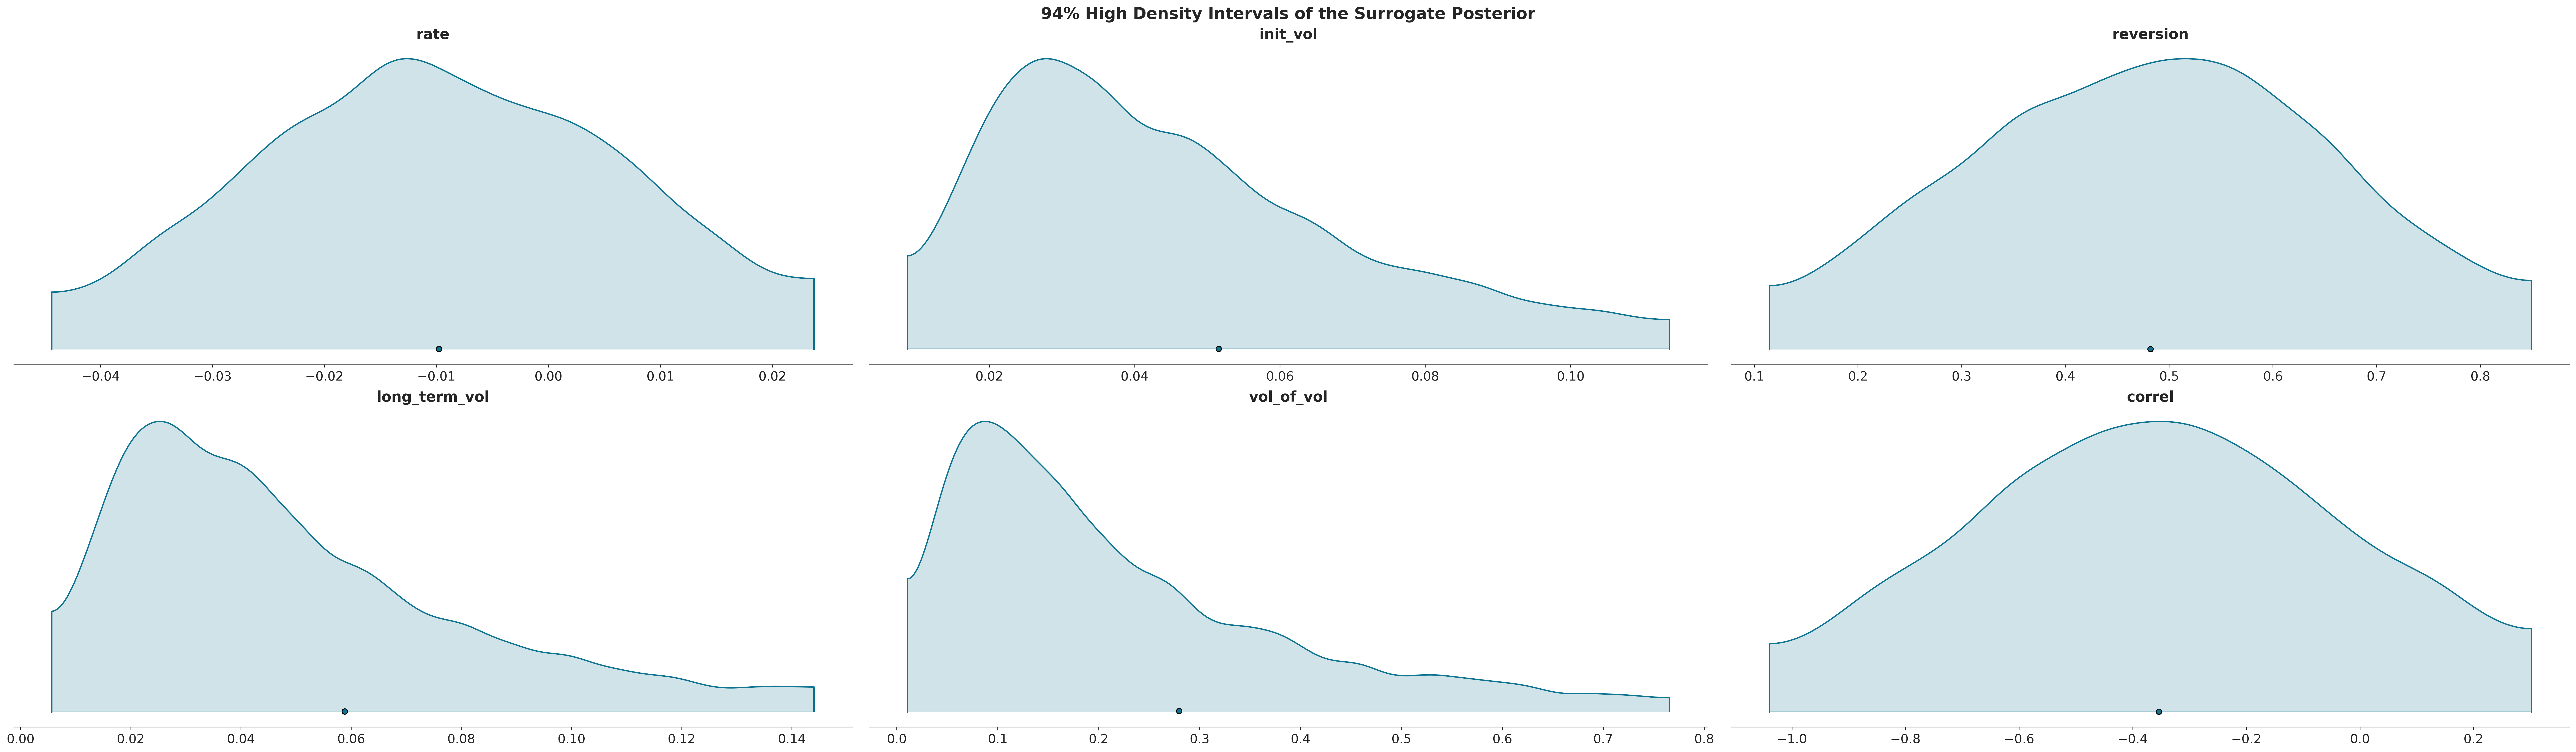

In [59]:
#| echo: false

az.style.use("arviz-doc")

axes = az.plot_density(
    [idata],
    data_labels=["Centered"],
    var_names=param_names,
    shade=0.2,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("94% High Density Intervals of the Surrogate Posterior")

plt.show()

Finally, these parameters drawn from the approximate posterior are passed to the simulator model to generate a sample of the posterior predictive distribution of call option prices.

In [13]:
def generate_posterior_predictive_prices(posterior_params, key):
    posterior_prices = vmap(compute_call_price,
                            in_axes=(None, 0, None, None, None))(
                                spot_price,
                                jnp.array(posterior_params),
                                strikes,
                                maturities,
                                key)
    filter = ~jnp.any(jnp.isnan(posterior_prices), axis=(1,2))
    posterior_prices = posterior_prices[filter]
    return posterior_prices

In [14]:
#| echo: false
#| output: false
posterior_prices = generate_posterior_predictive_prices(posterior_params, key)

/usr/local/lib/python3.10/dist-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


This sample can be used to compute a Monte Carlo estimate of the corresponding cumulative distribution function, with which we can assess how well the individual prices are explained by the calibrated model.

In [15]:
#| echo: false
#| output: false
print(jnp.mean(posterior_prices<market_calls[None], axis=0))

Array([[0.98828286, 0.78291434, 0.63634425, 0.6487005 , 0.7138901 ,
        0.8378781 ],
       [0.9394972 , 0.69599485, 0.6259054 , 0.65892625, 0.7771623 ,
        0.8434171 ],
       [0.8662122 , 0.6804431 , 0.5671069 , 0.6246272 , 0.7771623 ,
        0.84363014],
       [0.8227524 , 0.64081806, 0.5607158 , 0.63123137, 0.7648061 ,
        0.84703875],
       [0.7746059 , 0.6073711 , 0.5349382 , 0.56604177, 0.758628  ,
        0.83702594],
       [0.77290154, 0.6310183 , 0.5119301 , 0.54260755, 0.763954  ,
        0.8342565 ],
       [0.8402215 , 0.68512994, 0.49701744, 0.52854705, 0.7650192 ,
        0.8163613 ]], dtype=float32)

Ideally, the values of this matrix should be close to 0.5. When they are close to 0 or 1, it means that the observed prices fall in the tails of the posterior predictive distribution and can be considered as outliers under the probabilistic pricing model.

## Discussion
Machine learning models used to be criticized for their poor performance when it comes to probability estimation or quantification of uncertainty. This was arguably an obstacle to widespread adoption of machine learning in applications where quantifying risks with well-calibrated models is important, such as finance, healthcare, or engineering. Recent research in generative AI has led to the development of machine learning models of valid probability distributions, namely to generate samples from these distributions. They have unlocked powerful applications in scientific computing in problems of simulation-based inference. The example presented in this post illustrates the benefits that these probability-aware machine learning algorithms can bring to industry.

Firstly, we saw that paired with simulators, they allow to put error bars on inferred parameters, which makes it easier to assess model calibration and detect outliers in complex distributions.

Secondly, neural posterior estimation keeps the simulator model and the inference neural network separated, making it possible to increase the complexity of the model when it fails to capture certain phenomena in the data-generating process. All you have to do then is increase the dimensionality of the autoregressive flow and generate more synthetic data. In the option-pricing example, standard methods revolve around a geometric brownian motion to keep computations tractable, even though more complex processes such as the Heston model capture more characteristics of actual market prices. With a decoupled approach, there is no reason to favor a more simple model if the bias it introduces is too important.

Thirdly, in situations with sparse data, due to the Bayesian nature of neural posterior estimation, one can introduce prior knowledge about the parameters in the prior distribution, which would regularize the inference even if there weren't enough data points for standard methods.

Lastly, the computationally expensive part of neural posterior estimation is the generation of synthetic data and the learning of the surrogate posterior $q_{nn}(\theta \vert X)$, which both can be done in advance, and at inference time, once the data is observed, all that remains to do is to call the autoregressive flow once in parallel to generate a sample of the posterior. This is in general faster than a gradient-descent-based estimation of model parameters.


Google Colab notebook

Further work:
- Learn full joint with the sbi diffuser
- other conditional distribution

In [ ]:
posterior_predictive_prices = vmap(compute_call_price,
                                   in_axes=(None, 0, None, None, None))(
                                       spot_price,
                                       simulated_params,
                                       strikes,
                                       maturities,
                                       data_key)

posterior predictive risk minimization vs. empirical risk minimization